<a href="https://colab.research.google.com/github/rashmi05pathak/CS6910_Assignment3/blob/main/CS6910_Assignment3A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Experimentation for Question1***

In [ ]:
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

In [ ]:
#configure
num_encoder_tokens = 71
num_decoder_tokens = 93
latent_dim = 256

In [ ]:
#define an input sequence and process it
encoder_inputs = Input(shape=(None,num_encoder_tokens))
encoder = LSTM(latent_dim,return_state = True)
encoder_outputs,state_h,state_c = encoder(encoder_inputs)
encoder_states = [state_h,state_c]

In [ ]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

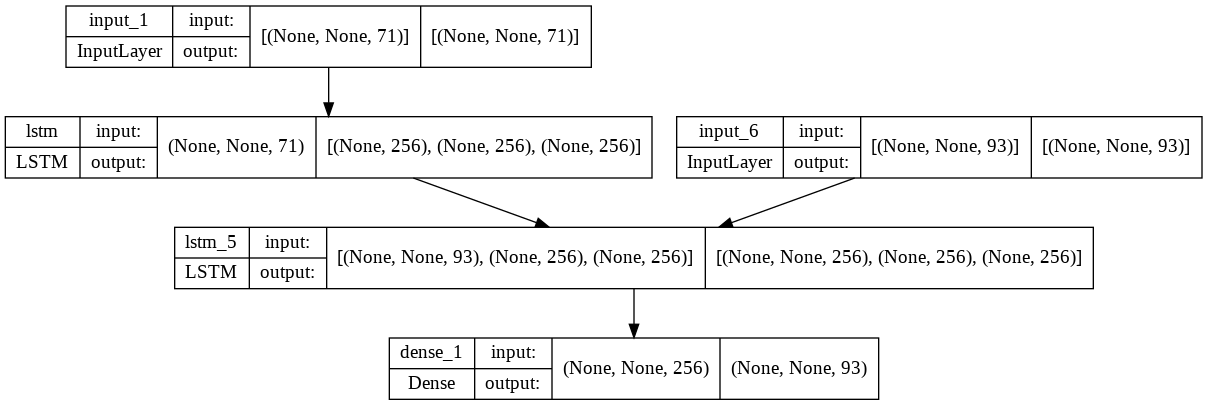

In [ ]:
plot_model(model,to_file='model.png',show_shapes = True)

In [ ]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)

In [ ]:
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)

NameError: ignored